# Working with timezones

Timestamp data can be timezone-naíve or timezone-aware. Using timestamped data with *staircase* has been a feature since the inception of the package, however the ability to work with timezone-aware date was only introduced in v1.6.0.

For many time-based applications of staircase it may suffice to ignore the concept of timezones and work with timezone-naíve data - an attractive option as working with timezones, and converting between them, can be tricky.  However many countries observe [Daylight Savings Time](https://en.wikipedia.org/wiki/Daylight_saving_time) which results in one day of the year having 23 hours, and another having 25 hours.  Now if you are computing some daily metric and do not take this into account then the calculations on those days will be incorrect, however the consequences, and indeed the calculated result, could well be immaterial.  However, that would be a lazy excuse for not implementing timezone support in staircase, and indeed for some applications the use of timezone-aware timestamps may be critical.

Given the sheer number of packages available for Python it may be of no surprise that there are several for dealing with timezones however there is one which is clearly the de facto standard: [pytz](http://pytz.sourceforge.net/).  We will demonstrate the use of Pytz in this article, however staircase supports any timezone package that [pandas](https://pandas.pydata.org/) supports.

In [1]:
import pandas as pd
import staircase as sc
import matplotlib.pyplot as plt
import pytz

Timezone-aware timestamps can be created directly in pandas:

In [2]:
timezone = pytz.timezone('Australia/Sydney')
ts_aware = pd.Timestamp('2020', tz=timezone)
ts_aware

Timestamp('2020-01-01 00:00:00+1100', tz='Australia/Sydney')

but they can also be created by *localizing* existing timezone-naive timestamps.

In [3]:
ts_naive = pd.Timestamp('2020')
ts_aware = ts_naive.tz_localize(timezone)
ts_aware

Timestamp('2020-01-01 00:00:00+1100', tz='Australia/Sydney')

Notice that the offset for Jan 1st 2020 is +11 hours.  This means that the time in Sydney, Australia, at that precise moment is 11 hours ahead of [Coordinated Universal Time](https://en.wikipedia.org/wiki/Coordinated_Universal_Time)  (UTC).  UTC is a successor to Greenwich Mean Time and is now the standard by which clocks and time are regulated around the world.  If we create a timezone-aware timestamp for the 1st of May 2020, then we get a different offset of +10 hours:

In [4]:
pd.Timestamp('2020-5-1', tz=timezone)

Timestamp('2020-05-01 00:00:00+1000', tz='Australia/Sydney')

This is because on the 5th of April 2020, Sydney (and the surrounding areas which observe the same timezone), wound clocks back at 3am to once again read 2am, in observance of Daylight Savings Time.  This means that the 5th of April was 25 hours long:

In [5]:
(pd.Timestamp('2020-4-6', tz=timezone) - pd.Timestamp('2020-4-5', tz=timezone))/pd.Timedelta('1h')

25.0

The fact that the 5th of April saw two occurences of 2am (and every time between 2am and 3am) is one of the reasons why timezones can be tricky - particularly if there is timezone-naíve timestamps which need to be made timezone-aware.

Daylight savings in Sydney resumes on the 4th of October 2020, where at 2am the clocks are wound forward an hour.  This means that 2:30am on the 4th of October 2020, for example, is not a time that exists in that timezone.  If we try to localize the corresponding timestamp we get an exception:

In [21]:
try:
    pd.Timestamp('2020-10-4 2:30').tz_localize(timezone)
except:
    import sys
    error = sys.exc_info()[1]
    print(f"{error.__class__.__name__}: {error}")

NonExistentTimeError: 2020-10-04 02:30:00


We can also localize pandas Series of timestamps.  For example, if we have the following timezone-naíve data:

In [7]:
data = pd.read_csv(r"../examples/data/asset_use.csv", parse_dates=['start', 'end'], dayfirst=True)
series_of_timestamps = data.start

In [8]:
series_of_timestamps

0       2020-01-01 00:06:00
1       2020-01-01 00:50:00
2       2020-01-01 00:54:00
3       2020-01-01 02:14:00
4       2020-01-01 02:29:00
                ...        
15079   2020-12-31 19:28:00
15080   2020-12-31 20:59:00
15081   2020-12-31 22:15:00
15082   2020-12-31 22:40:00
15083   2020-12-31 22:50:00
Name: start, Length: 15084, dtype: datetime64[ns]

then we can convert all timestamps to be timezone-aware by first using the [dt accessor](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.html) and then calling the *tz_localize* method. 

In [9]:
series_of_timestamps_tz = series_of_timestamps.dt.tz_localize(timezone)
series_of_timestamps_tz

0       2020-01-01 00:06:00+11:00
1       2020-01-01 00:50:00+11:00
2       2020-01-01 00:54:00+11:00
3       2020-01-01 02:14:00+11:00
4       2020-01-01 02:29:00+11:00
                   ...           
15079   2020-12-31 19:28:00+11:00
15080   2020-12-31 20:59:00+11:00
15081   2020-12-31 22:15:00+11:00
15082   2020-12-31 22:40:00+11:00
15083   2020-12-31 22:50:00+11:00
Name: start, Length: 15084, dtype: datetime64[ns, Australia/Sydney]

As mentioned earlier we can use timezone-aware data with staircase but we need to declare the timezone when initialising a Stairs object.

In [10]:
example_tz = sc.Stairs(use_dates=True, tz=timezone)
example_tz

<staircase.Stairs, id=2129709122568, dates=True, tz=Australia/Sydney>

In the example below we use the first 6 timestamps from the above series to add layers to the timezone-aware step function.

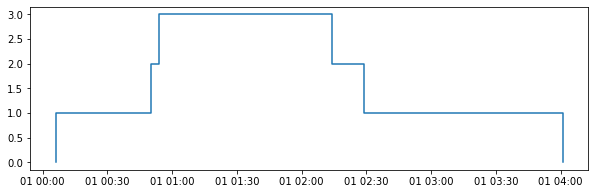

In [11]:
example_tz.layer(series_of_timestamps_tz[:3], series_of_timestamps_tz[3:6])
example_tz.plot(ax=plt.subplots(figsize=(10,3))[1])

Note that if we had tried using the timezone-naíve data, *series_of_timestamps*, with the layer function we would get an error.  If we initialise a Stairs object with a timezone, then all interactions with that Stairs object must be done in the context of that timezone.  A similar requirement is found in binary operations with pandas.Timestamps, such as subtraction or greater-than, which are only permitted if the timestamps are either timezone-naíve or have the same timezone.

For staircase, we require (when using Stairs with dates):

- using a timezone-aware timestamp when using the *Stairs.sample* method
- both operands in binary operations, such as + or >=, must both be timezone-naíve or have the same timezone
- *lower* and *upper* parameters in methods such as *mean*, *integrate*, *describe*, *hist* etc must have the same timezone as the Stairs instance the method is called on

This last requirement in particular may lead to constantly needing to localize timestamps, eg:

In [28]:
example_tz.mean(pd.Timestamp('2020-1-1 1:00', tz=timezone), pd.Timestamp('2020-1-1 3:00', tz=timezone))

2.358333333337214

Users of staircase may find it useful to create a function to adds timezones to the timestamps, and use in place of the pd.Timestamp constructor:

In [29]:
tz_timestamp = lambda t: pd.Timestamp(t, tz=timezone)
example_tz.mean(tz_timestamp('2020-1-1 1:00'), tz_timestamp('2020-1-1 3:00'))

2.358333333337214

For a further example of working with timezones see [Case study: asset utilisation (with timezones)](../examples/Case Study Asset Utilisation TZ.ipynb).

**Authors:**

- Riley Clement (github @venaturum)